In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
from scipy.stats import t as ttt

page = 'find'
time_range = 7
upper_bound = 20

bootstrap_sample_times = 5000

b_lists = []
c_lists = []
d_lists = []

# read data
all_photo_interaction = pd.read_csv(rf'../data/personal_{page}_all_photo_interaction.csv')
all_photo_interaction.drop(columns=['play_cnt', 'distbt_cnt'], inplace=True)
all_photo_interaction.rename(columns={'show_cnt':'all_photo_show_cnt','play_duration':'all_photo_play_duration'}, inplace=True)
all_photo_interaction['p_date'] = pd.to_datetime(all_photo_interaction['p_date'], format=rf'%Y%m%d')

all_misinformation_interaction = pd.read_csv(rf'../data/personal_{page}_misinformation_interaction_three_months.csv')
all_misinformation_interaction['p_date'] = pd.to_datetime(all_misinformation_interaction['p_date'], format=rf'%Y%m%d')
print(all_misinformation_interaction.shape)

all_misinformation_interaction = pd.merge(all_misinformation_interaction, all_photo_interaction, how='left', on=['p_date','device_id'])
del all_photo_interaction

###################################### statistic for Fig.B #################################
begin_date_list = ['2022-11-01','2022-11-15','2022-11-29','2022-12-13','2022-12-27','2023-01-10']
last_date_list = ['2022-11-14','2022-11-28','2022-12-12','2022-12-26','2023-01-09','2023-01-23']
color_lists = ['#403990','#80A6E2','#aadce0','#FBDD85','#F46F43','#CF3D3E']

for t, (first_date, last_date) in enumerate(zip(begin_date_list, last_date_list)):
    
    begin_date = pd.to_datetime(first_date)
    end_date = pd.to_datetime(last_date)
    misinformation_interaction = all_misinformation_interaction[
    (all_misinformation_interaction['p_date'] >= begin_date) &
    (all_misinformation_interaction['p_date'] <= end_date)].copy()

    
    misinformation_interaction['time_slot'] = (misinformation_interaction['p_date'] - begin_date).dt.days // time_range
    misinformation_target_matrix = misinformation_interaction.pivot_table(index='device_id', columns='time_slot', values = 'valid_play_cnt', aggfunc = np.sum)
    misinformation_target_matrix.fillna(0,inplace=True)
    misinformation_target_matrix = misinformation_target_matrix.astype('int')

    misinfo_next_target_array = [[] for _ in range(upper_bound+1)]  
    for _, row in tqdm(misinformation_target_matrix.iterrows(),total=misinformation_target_matrix.shape[0]):
        current_value = row[0]
        nex_value = row[1]
        if current_value > upper_bound:
            continue
        misinfo_next_target_array[current_value].append(nex_value)
    
    value_delta_list = []
    x_label = []
    x_ticket = []
    x_data = []
    lower_bounds = [] 
    upper_bounds = []

    for current_value, next_value_array in  enumerate(misinfo_next_target_array):
        if(len(next_value_array) == 0):
            continue
        next_value_array = np.array(next_value_array) - current_value
        bootstrap_medians = []
        # error bar
        for _ in range(bootstrap_sample_times):
            bootstrap_sample = np.random.choice(next_value_array, size=len(next_value_array), replace=True)
            median = np.median(bootstrap_sample)
            bootstrap_medians.append(median)
        lower_percentile = 2.5
        upper_percentile = 97.5
        lb = np.percentile(bootstrap_medians, lower_percentile)
        ub = np.percentile(bootstrap_medians, upper_percentile)
        median = np.median(next_value_array)

        if ((ub - median) > 2) or ((median - lb) > 2):
            lower_bounds.append(median-lb)
            upper_bounds.append(ub-median)
            value_delta_list.append(median)
            x_data.append(current_value)
            break

        lower_bounds.append(median-lb)
        upper_bounds.append(ub-median)
        value_delta_list.append(median)
        x_data.append(current_value)
    
    b_lists.append((x_data,value_delta_list,lower_bounds,upper_bounds))

#################### statistic for Fig.C.D.E.############################
all_misinformation_interaction['time_slot'] = (all_misinformation_interaction['p_date'] - pd.to_datetime('2022-11-01')).dt.days // time_range
all_photo_show_matrix = all_misinformation_interaction.pivot_table(index='device_id', columns='time_slot', values = 'all_photo_show_cnt', aggfunc=np.sum)
misinfo_show_matrix = all_misinformation_interaction.pivot_table(index='device_id', columns='time_slot', values = 'show_cnt', aggfunc=np.sum)
misinfo_valid_play_matrix = all_misinformation_interaction.pivot_table(index='device_id', columns='time_slot', values = 'valid_play_cnt', aggfunc=np.sum)
all_photo_play_duration_matrix = all_misinformation_interaction.pivot_table(index='device_id', columns='time_slot', values = 'all_photo_play_duration', aggfunc=np.sum)

misinfo_valid_play_matrix = misinfo_valid_play_matrix.fillna(0)  
misinfo_show_matrix = misinfo_show_matrix.fillna(0)
all_photo_show_matrix = all_photo_show_matrix.fillna(0)
all_photo_play_duration_matrix = all_photo_play_duration_matrix.fillna(0)

current_conversion_array = [[] for _ in range(upper_bound+1)]   
next_conversion_array = [[] for _ in range(upper_bound+1)] 
current_ratio_array = [[] for _ in range(upper_bound+1)]   
next_ratio_array = [[] for _ in range(upper_bound+1)] 
current_all_photo_play_druation_array = [[] for _ in range(upper_bound+1)]   
next_all_photo_play_duration_array = [[] for _ in range(upper_bound+1)] 

for i in range(0, 92//time_range,2):
    current_valid_play = misinfo_valid_play_matrix.iloc[:, i] 
    current_show = misinfo_show_matrix.iloc[:, i]   
    next_valid_play = misinfo_valid_play_matrix.iloc[:, i+1]
    next_show = misinfo_show_matrix.iloc[:,i+1]
    current_all_photo_show = all_photo_show_matrix.iloc[:, i] 
    next_all_photo_show = all_photo_show_matrix.iloc[:, i+1]
    current_all_photo_play_druation = all_photo_play_duration_matrix.iloc[:, i] 
    next_all_photo_play_duration = all_photo_play_duration_matrix.iloc[:, i+1]

    result_df = pd.concat([current_valid_play, current_show, next_valid_play, next_show, current_all_photo_show, next_all_photo_show,current_all_photo_play_druation,next_all_photo_play_duration], axis=1)

    result_df.columns = [ 'current_valid_play', 'current_show', 'next_valid_play', 'next_show', 'current_all_photo_show', 'next_all_photo_show','current_all_photo_play_druation','next_all_photo_play_duration']
    result_df = result_df[result_df['current_show'] > 0].copy()   
    result_df = result_df[result_df['next_show'] > 0].copy()    

    for i, row in tqdm(result_df.iterrows(), total = result_df.shape[0]):
        current_value = int(row['current_show']) 
        if row['current_show'] > upper_bound:
            continue

        current_conversion_array[current_value].append(row['current_valid_play'] / row['current_show'])
        next_conversion_array[current_value].append(row['next_valid_play'] / row['next_show'])
        current_ratio_array[current_value].append(row['current_show'] / row['current_all_photo_show'])
        next_ratio_array[current_value].append( row['next_show'] / row['next_all_photo_show'])
        current_all_photo_play_druation_array[current_value].append(row['current_all_photo_play_druation'])
        next_all_photo_play_duration_array[current_value].append(row['next_all_photo_play_duration'])
        current_all_photo_play_druation_array[current_value].append(row['current_all_photo_play_druation'])
        next_all_photo_play_duration_array[current_value].append(row['next_all_photo_play_duration'])


mean_misinfo_conversion_rate_1 = []
sem_misinfo_conversion_rate_1 = []
for value_array in current_conversion_array:
    if len(value_array) != 0:
        mean = np.mean(np.array(value_array))
        sem = np.std(np.array(value_array)) / np.sqrt(len(value_array))
        mean_misinfo_conversion_rate_1.append(mean)
        sem_misinfo_conversion_rate_1.append(1.96 * sem)  
    else:
        mean_misinfo_conversion_rate_1.append(0)
        sem_misinfo_conversion_rate_1.append(0)

mean_misinfo_conversion_rate_2 = []
sem_misinfo_conversion_rate_2 = []
for value_array in next_conversion_array:
    if len(value_array) != 0:
        mean = np.mean(np.array(value_array))
        sem = np.std(np.array(value_array)) / np.sqrt(len(value_array))
        mean_misinfo_conversion_rate_2.append(mean)
        sem_misinfo_conversion_rate_2.append(1.96 * sem)  
    else:
        mean_misinfo_conversion_rate_2.append(0)
        sem_misinfo_conversion_rate_2.append(0)

mean_misinfo_ratio_1 = []
sem_misinfo_ratio_1 = []
for value_array in current_ratio_array:
    if len(value_array) != 0:
        mean = np.mean(np.array(value_array))
        sem = np.std(np.array(value_array)) / np.sqrt(len(value_array))
        mean_misinfo_ratio_1.append(mean)
        sem_misinfo_ratio_1.append(1.96 * sem) 
    else:
        mean_misinfo_ratio_1.append(0)
        sem_misinfo_ratio_1.append(0)


mean_misinfo_ratio_2 = []
sem_misinfo_ratio_2 = []
for value_array in next_ratio_array:
    if len(value_array) != 0:
        mean = np.mean(np.array(value_array))
        sem = np.std(np.array(value_array)) / np.sqrt(len(value_array))
        mean_misinfo_ratio_2.append(mean)
        sem_misinfo_ratio_2.append(1.96 * sem)  
    else:
        mean_misinfo_ratio_2.append(0)
        sem_misinfo_ratio_2.append(0)

all_photo_play_duration_1 = []
sem_all_photo_play_duration_1 = []
for value_array in current_all_photo_play_druation_array:
    if len(value_array) != 0:
        mean = np.mean(np.array(value_array))
        mean = mean / 1000 / 60 / 60   
        sem = np.std(np.array(value_array)) / np.sqrt(len(value_array))
        sem = sem / 1000 / 60 / 60  
        all_photo_play_duration_1.append(mean)
        sem_all_photo_play_duration_1.append(1.96 * sem)  
    else:
        all_photo_play_duration_1.append(0)
        sem_all_photo_play_duration_1.append(0)

all_photo_play_duration_2 = []
sem_all_photo_play_duration_2 = []
for value_array in next_all_photo_play_duration_array:
    if len(value_array) != 0:
        mean = np.mean(np.array(value_array))
        mean = mean / 1000 / 60 / 60     
        sem = np.std(np.array(value_array)) / np.sqrt(len(value_array))
        sem = sem / 1000 / 60 / 60   
        all_photo_play_duration_2.append(mean)
        sem_all_photo_play_duration_2.append(1.96 * sem)  
    else:
        all_photo_play_duration_2.append(0)
        sem_all_photo_play_duration_2.append(0)

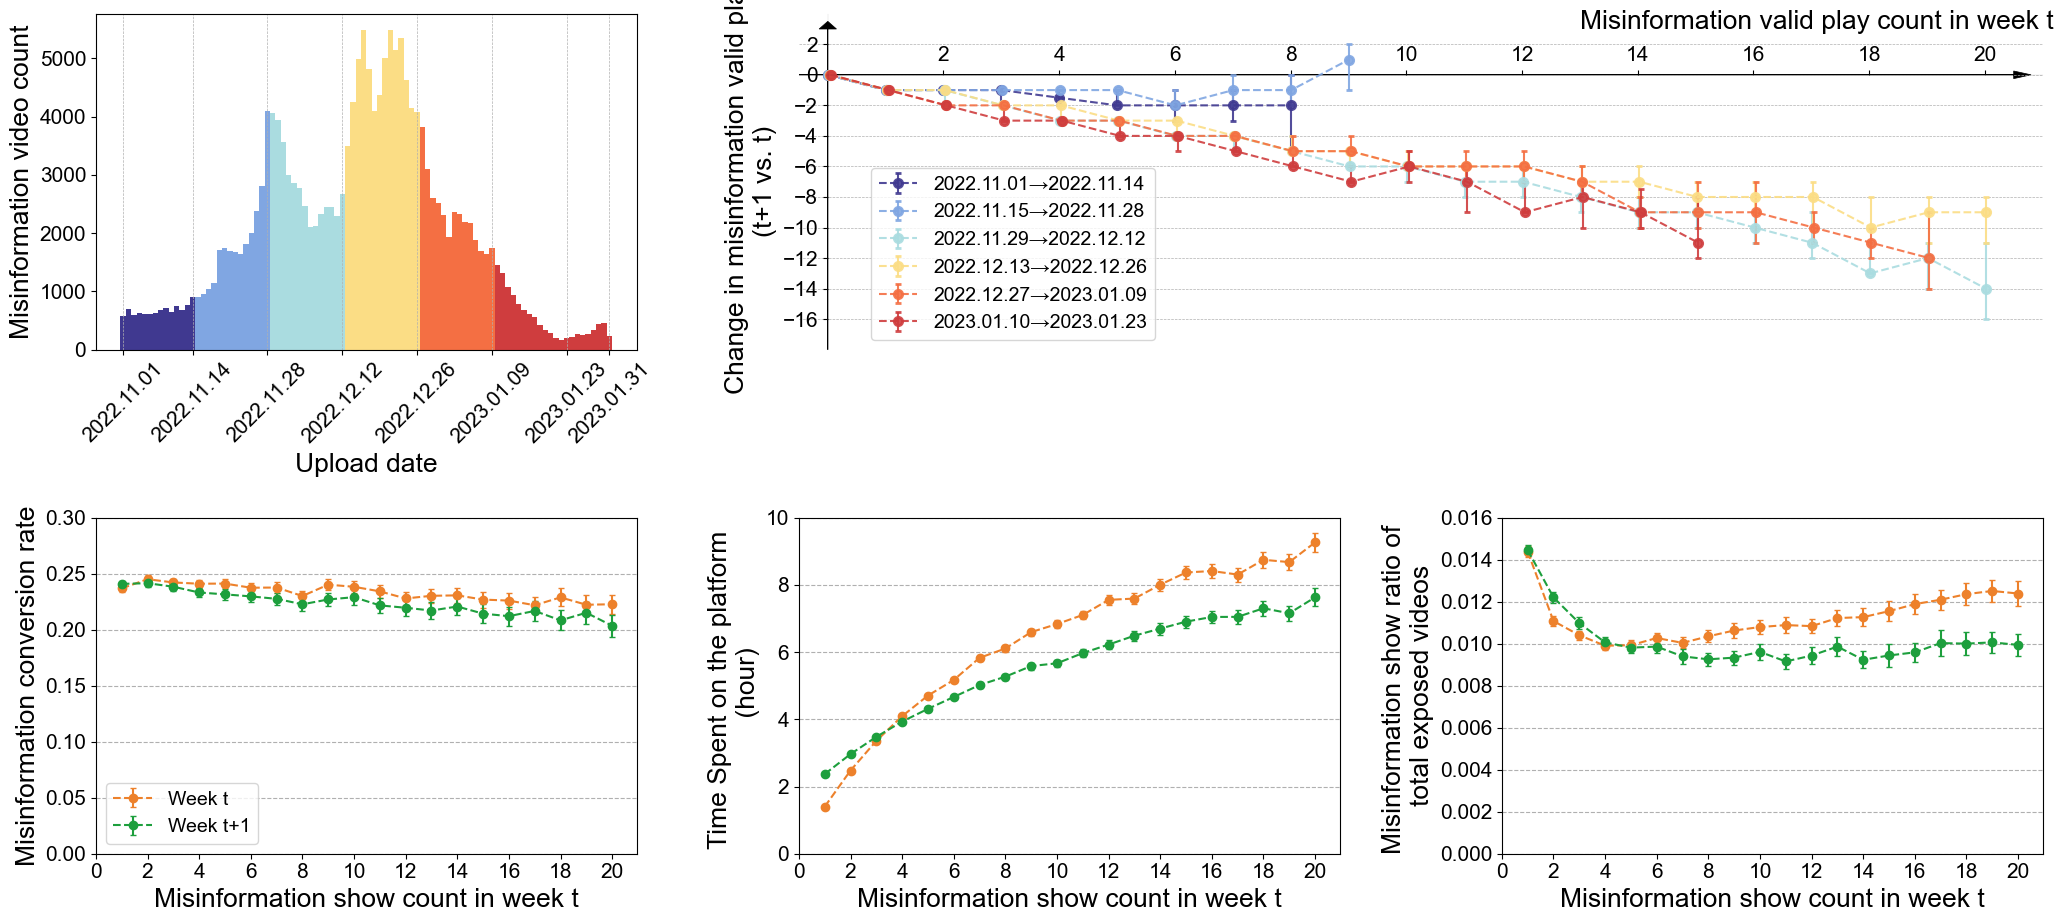

In [4]:
from matplotlib import rcParams

# 设置全局字体为lmss
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

font_size = 19
tick_size = 15
font_weight = 500
cap_size = 2

fig = plt.figure(figsize=(21, 10))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1])  
ax0 = plt.subplot(gs[0, 0])  
ax1 = plt.subplot(gs[0, 1:])  
ax2 = plt.subplot(gs[1, 0])  
ax3 = plt.subplot(gs[1, 1])  
ax4 = plt.subplot(gs[1, 2])  

##################################### Fig.A #################################
misinfo_df = pd.read_csv(rf'../data/day_misinfo_num.csv')
misinfo_df['upload_dt'] = pd.to_datetime(misinfo_df['upload_dt'], format=rf'%Y-%m-%d')
misinfo_num = misinfo_df.groupby('upload_dt')['misinfo_num'].sum()
color_lists = ['#403990']*14+['#80A6E2']*14+['#aadce0']*14+['#FBDD85']*14+['#F46F43']*14+['#CF3D3E']*23
ax0.bar(misinfo_num.index, misinfo_num.values, color = color_lists, width=1.0)
x_ticks = [pd.to_datetime('2022-11-01'), pd.to_datetime('2022-11-14') ,pd.to_datetime('2022-11-28'), pd.to_datetime('2022-12-12') ,pd.to_datetime('2022-12-26'), pd.to_datetime('2023-01-09') ,pd.to_datetime('2023-01-23'),pd.to_datetime('2023-01-31')]
ax0.set_xticks(x_ticks)
ax0.set_xticklabels(x_ticks, rotation=45)
date_format = mdates.DateFormatter('%Y.%m.%d')
ax0.xaxis.set_major_formatter(date_format)
ax0.xaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax0.set_ylabel('Misinformation video count', fontsize = font_size, fontweight = font_weight)
ax0.set_xlabel('Upload date', fontsize = font_size, fontweight = font_weight)
ax0.tick_params(axis='x', labelsize=tick_size)
ax0.tick_params(axis='y',labelsize= tick_size) 

#################################### Fig.B ########################################
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_position('zero')
ax1.spines['bottom'].set_position('zero')
ax1.spines['left'].set_position('zero')
ax1.spines['left'].set_color('black')
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_linewidth(0.05)
ax1.spines['bottom'].set_linewidth(0.05)
ax1.set_xlim(-0.5,upper_bound+1)
ax1.set_ylim(-18, 4)
integer_y_ticks = range(-16, 3, 2) 
ax1.set_yticks(integer_y_ticks)
integer_x_ticks = range(2, 21, 2)  
ax1.set_xticks(integer_x_ticks)
ax1.arrow(-0.5, 0, upper_bound+1, 0, head_width=0.5, head_length=0.3, fc='black', ec='black', lw=0.5)
ax1.arrow(0, -18, 0, 18 + 3, head_width=0.3, head_length=0.5, fc='black', ec='black', lw=0.5)
ax1.grid(True, linestyle='--', linewidth=0.5, axis='y')  # 设置 axis='x'
ax1.annotate('Misinformation valid play count in week t', xy=(13, 3), fontsize = font_size, fontweight = font_weight)
# ax1.annotate('change in valid play (t+1 vs. t)', xy=(-2, -16), fontsize=18, rotation = 90)
ax1.set_ylabel('Change in misinformation valid play \n(t+1 vs. t)', fontsize = font_size, fontweight = font_weight, rotation = 90)
ax1.tick_params(axis='x', labelsize=tick_size, bottom=False, labelbottom=False, top=True, labeltop=True)
ax1.tick_params(axis='y',labelsize= tick_size) 
for label in ax1.get_xticklabels():
    label.set_weight(font_weight)
for label in ax1.get_yticklabels():
    label.set_weight(font_weight)

color_lists = ['#403990','#80A6E2','#aadce0','#FBDD85','#F46F43','#CF3D3E']
for t in range(6):
    (x_data, value_delta_list, lower_bounds, upper_bounds) = b_lists[t]
    ax1.errorbar(np.array(x_data)+0.01*t, value_delta_list, yerr=(lower_bounds,upper_bounds), linestyle='--', marker='o', color=color_lists[t], label=f"{begin_date_list[t].replace('-', '.')}→{last_date_list[t].replace('-', '.')}", alpha=0.9, capsize=cap_size, markeredgewidth=2)
ax1.legend(loc='lower left', bbox_to_anchor=(0.05, 0), fontsize = font_size-5)

########################################## Fig.C. ##############################################
x_data = np.arange(1, 21)
y_data = mean_misinfo_conversion_rate_1[1:]
ax2.errorbar(x_data, y_data, yerr=sem_misinfo_conversion_rate_1[1:], fmt='o', color='#ed812b', elinewidth=1.5, capsize=cap_size, linestyle='--', label = 'Week t')
y_data = mean_misinfo_conversion_rate_2[1:]
ax2.errorbar(x_data, y_data, yerr=sem_misinfo_conversion_rate_2[1:], fmt='o', color='#1d9f3d', elinewidth=1.5, capsize=cap_size, linestyle='--', label = 'Week t+1')
ax2.set_xlabel('Misinformation show count in week t',fontsize = font_size, fontweight = font_weight)
ax2.set_ylabel('Misinformation conversion rate',fontsize = font_size, fontweight = font_weight)
ax2.set_xticks(np.arange(0,21,2))
ax2.grid(axis='y', linestyle='--')
ax2.legend(loc='lower left', fontsize=font_size-5)
ax2.tick_params(axis='x', labelsize=tick_size)
ax2.tick_params(axis='y',labelsize= tick_size) 
if page == 'featured':
    ax2.set_ylim(bottom=0, top=0.6) 
else:
    ax2.set_ylim(bottom=0, top=0.3)


######################################### Fig.E. ################################################
y_data = all_photo_play_duration_1[1:]
ax3.errorbar(x_data, y_data, yerr=sem_all_photo_play_duration_1[1:], fmt='o', color='#ed812b', elinewidth=1.5, capsize=cap_size, linestyle='--', label = 'Week t')
y_data = all_photo_play_duration_2[1:]
ax3.errorbar(x_data, y_data, yerr=sem_all_photo_play_duration_2[1:], fmt='o', color='#1d9f3d', elinewidth=1.5, capsize=cap_size, linestyle='--', label = 'Week t+1')
ax3.set_xlabel('Misinformation show count in week t',fontsize = font_size, fontweight = font_weight)
ax3.set_ylabel('Time Spent on the platform \n (hour)',fontsize = font_size, fontweight = font_weight)
ax3.set_xticks(np.arange(0,21,2))
ax3.grid(axis='y', linestyle='--')
ax3.tick_params(axis='x', labelsize=tick_size)
ax3.tick_params(axis='y',labelsize= tick_size) 
if page == 'featured':
    ax3.set_ylim(bottom=0, top=17.5)
else:
    ax3.set_ylim(bottom=0, top=10) 

########################################## Fig.F. ##############################################
y_data = mean_misinfo_ratio_1[1:]
ax4.errorbar(x_data, y_data, yerr=sem_misinfo_ratio_1[1:], fmt='o', color='#ed812b', elinewidth=1.5, capsize=cap_size, linestyle='--', label = 'Week t')
y_data = mean_misinfo_ratio_2[1:]
ax4.errorbar(x_data, y_data, yerr=sem_misinfo_ratio_2[1:], fmt='o', color='#1d9f3d', elinewidth=1.5, capsize=cap_size, linestyle='--', label = 'Week t+1')
ax4.set_xlabel('Misinformation show count in week t',fontsize = font_size, fontweight = font_weight)
ax4.set_ylabel('Misinformation show ratio of \ntotal exposed videos',fontsize = font_size, fontweight = font_weight)
ax4.set_xticks(np.arange(0,21,2))
ax4.grid(axis='y', linestyle='--')
ax4.tick_params(axis='x', labelsize=tick_size)
ax4.tick_params(axis='y',labelsize= tick_size) 
ax4.set_ylim(bottom=0)
if page == 'featured':
    ax4.set_ylim(bottom=0)
else:
    ax4.set_ylim(bottom=0, top=0.016)

plt.subplots_adjust(left=0.05, bottom=0.08, right=0.977, top=0.92, wspace=0.3, hspace=0.5)
plt.show()